# CS231n Assignment 1
# Softmax Regression

- Building the general architecture of a softmax regression algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent)
- Gather all three functions above into a main model function, in the right order.

In [2]:
import random
import numpy as np
from past.builtins import xrange
from local_utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time
import sys

## CIFAR-10 visualization [0pt]

Run the next cell to display a grid of example images.
This ensures you can load the dataset - may take a few seconds to print

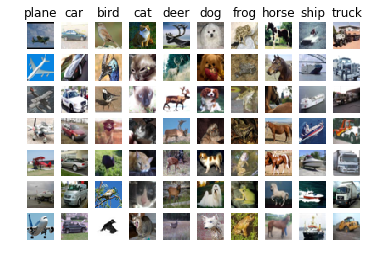

In [3]:
# Load the raw CIFAR-10 data. Link to the data: https://www.cs.toronto.edu/~kriz/cifar.html

cifar10_dir = '../../data/cifar/'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## CIFAR-10 load data

Run the next cell to define a data helper function that does some basic preprocessing.

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../data/cifar'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    # these are numpy arrays, not lists - that's why this indexing works.
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Task 1: Softmax - Loss Function and Gradients

In [5]:
def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes,
    and we operate on minibatches of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    
    num_classes = W.shape[1]
    num_samples = X.shape[0] #: #of training samples passed in batch X
    

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    num_pix = W.shape[0] #: number of pixels in an image (3073)
        
    for i in range(num_samples):
        scores = X[i, :].dot(W)
        exp_scores = np.exp(scores)

        prob_scores = exp_scores/np.sum(exp_scores)

        for d in range(num_pix):
            for k in range(num_classes):
                if k == y[i]:
                    dW[d, k] += X.T[d, i] * (prob_scores[k]-1)
                else:
                    dW[d, k] += X.T[d, i] * prob_scores[k]

        loss += -np.log(prob_scores[y[i]])

    loss /= num_samples
    loss += 0.5 * reg * np.sum(W**2)

    dW /= num_samples
    dW += reg * W

    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW


# Task 2: Softmax-  Loss Function & Gradients - Vectorized

Here I implement a vectorized version of the previous function.

In [8]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.
    Inputs have dimension D, there are C classes,
    and we operate on minibatches of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
  
  

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    
    num_samples = X.shape[0]
    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    
    num_train = X.shape[0]

    scores = np.dot(X, W)
    exp_scores = np.exp(scores)
    prob_scores = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
    correct_log_probs = -np.log(prob_scores[range(num_train), y])
    loss = np.sum(correct_log_probs)
    loss /= num_train
    loss += 0.5 * reg * np.sum(W**2)

    # calculate gradients
    dscores = prob_scores
    dscores[range(num_train), y] -= 1
    dW = np.dot(X.T, dscores)
    dW /= num_train
    dW += reg * W


    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW

# Check: Performance Comparison:
The two versions should compute the same results, but the vectorized version should be much faster.

In [9]:
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff = tic - toc
print('Naive loss: %e computed in %fs' % (loss_naive, diff))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff_vec = tic - toc
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, diff_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Runtime abs. difference: %f seconds' % (diff_vec - diff))
print('Runtime rel. improvement: %f percent' % (1 - (diff_vec / diff)))

Naive loss: 2.315223e+00 computed in -14.260334s
Vectorized loss: 2.315223e+00 computed in 0.000000s
Loss difference: 0.000000
Gradient difference: 0.000000
Runtime abs. difference: 14.260334 seconds
Runtime rel. improvement: 1.000000 percent


# Task 3: Softmax - Stochastic Gradient Descent

In [10]:
def train_SGD(X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    W: A numpy array of shape (D, C) containing weights
    loss_history: A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
   
    # Generate a random softmax weight matrix
    W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in xrange(num_iters):
        X_batch = None
        y_batch = None

        #########################################################################
        # TODO:                                                                 #
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in this round of gradient descent.        #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
        # and y_batch should have shape (batch_size,)                           #
        #                                                                       #
        # Hint: Use np.random.choice to generate indices. Sampling with         #
        # replacement is faster than sampling without replacement.              #
        #########################################################################
        
        random_samples_indx = np.random.choice(num_train,batch_size)
        X_batch = X[random_samples_indx,:]
        y_batch = y[random_samples_indx]
        
        
        #########################################################################
        #                       END OF YOUR CODE                                #
        #########################################################################

        # evaluate loss and gradient
        loss, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg)
        loss_history.append(loss)

        # perform parameter update
        #########################################################################
        # TODO:                                                                 #
        # Update the weights using the gradient and the learning rate.          #
        #########################################################################

        W -= grad * learning_rate
        
        #########################################################################
        #                       END OF YOUR CODE                                #
        #########################################################################

        if verbose and it % 100 == 0:
            print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return W, loss_history

# Task 4: Softmax - Predictor Function
In the next cell, I implement a function that predicts classes given a trained classifier and a
batch of data points.

In [11]:
def predict(W, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    
    s = np.dot(X, W)
    y_pred = np.argmax(s, axis=1)
    
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred

# Check: Predictor Accuracy [0pt]

The expected accuracy is about 33%, because the model is quite primitive

In [12]:
W, loss_hist = train_SGD(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=2500,
            batch_size=200, verbose=True)
y_train_pred = predict(W,X_train)
train_acc = np.mean(y_train == y_train_pred)
print("training accuracy: "+ str(train_acc))

iteration 0 / 2500: loss 392.455670
iteration 100 / 2500: loss 236.981571
iteration 200 / 2500: loss 144.198103
iteration 300 / 2500: loss 87.630306
iteration 400 / 2500: loss 53.979283
iteration 500 / 2500: loss 33.328846
iteration 600 / 2500: loss 21.035152
iteration 700 / 2500: loss 13.533989
iteration 800 / 2500: loss 8.984355
iteration 900 / 2500: loss 6.186888
iteration 1000 / 2500: loss 4.516177
iteration 1100 / 2500: loss 3.582396
iteration 1200 / 2500: loss 2.953350
iteration 1300 / 2500: loss 2.555811
iteration 1400 / 2500: loss 2.303648
iteration 1500 / 2500: loss 2.166660
iteration 1600 / 2500: loss 2.117446
iteration 1700 / 2500: loss 2.128805
iteration 1800 / 2500: loss 2.035295
iteration 1900 / 2500: loss 2.066275
iteration 2000 / 2500: loss 2.006529
iteration 2100 / 2500: loss 2.101414
iteration 2200 / 2500: loss 2.039371
iteration 2300 / 2500: loss 2.081716
iteration 2400 / 2500: loss 2.031139
training accuracy: 0.350530612245


# Task 5: Softmax - Hyperparameter Tuning

Here the goal is to find the optimal hyperparameters 
(regularization strength and learning rate) using the validation set.
Different ranges for the learning
rates and regularization strengths are used; a classification accuracy of over 0.35 on the validation set should be achieved.

In [13]:
results = {}
best_val = -1
best_W = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# the best trained softmax classifer in best_W.                                #
################################################################################

for lr in learning_rates:
    for rs in regularization_strengths:
        # instantiate classifier
        
        W = train_SGD(X_train, y_train, learning_rate=lr, reg=rs, num_iters=1500, verbose=True)[0]

        # predict values for train and valid
        y_train_pred = predict(W, X_train)
        y_val_pred = predict(W, X_val)

        # compute accuracies
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_W = W

        # store accuracies for given lr and rs
        results[(lr, rs)] = train_accuracy, val_accuracy

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation @ cross-validation: %f' % best_val)

iteration 0 / 1500: loss 383.564009
iteration 100 / 1500: loss 232.158155
iteration 200 / 1500: loss 140.692434
iteration 300 / 1500: loss 85.952725
iteration 400 / 1500: loss 52.685882
iteration 500 / 1500: loss 32.616194
iteration 600 / 1500: loss 20.610111
iteration 700 / 1500: loss 13.156427
iteration 800 / 1500: loss 8.826327
iteration 900 / 1500: loss 6.118223
iteration 1000 / 1500: loss 4.474302
iteration 1100 / 1500: loss 3.448154
iteration 1200 / 1500: loss 3.000143
iteration 1300 / 1500: loss 2.506398
iteration 1400 / 1500: loss 2.401782
iteration 0 / 1500: loss 775.277164
iteration 100 / 1500: loss 284.178434
iteration 200 / 1500: loss 105.190894
iteration 300 / 1500: loss 39.863213
iteration 400 / 1500: loss 15.934062
iteration 500 / 1500: loss 7.161856
iteration 600 / 1500: loss 3.933591
iteration 700 / 1500: loss 2.782658
iteration 800 / 1500: loss 2.344301
iteration 900 / 1500: loss 2.150231
iteration 1000 / 1500: loss 2.114376
iteration 1100 / 1500: loss 2.077265
iterat

# Check: Prediction on Test Set

Checking the model on the test data

In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = predict(best_W,X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.358000
